<a href="https://colab.research.google.com/github/mandosanti06/X-RAI/blob/main/X_RAI_Workshop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# X-RAI

This project uses deep learning to automatically detect bone fractures from musculoskeletal X-ray images using the MURA v1.1 dataset. A lightweight convolutional neural network (MobileNetV2) is trained to classify each image as “Fractured” or “Not Fractured.”


Stack Used for the project:

- Dataset: MURA v1.1 (Stanford ML Group)
- Model: MobileNetV2 (pretrained on ImageNet)
- Frameworks: PyTorch, Torchvision
- Visualization: Grad-CAM, Matplotlib
- Environment: Google Colab / Kaggle (GPU)

Features:
- Fracture classification with up to ~86% accuracy on validation subset
- Fast training setup using MobileNet + resized images
- Grad-CAM visualizations to interpret model decisions
- Label and prediction overlays with probabilities


## Install & Download MURA v.1.1 Dataset

**Description**: This code block installs the kagglehub package, imports it, and then uses it to download the MURA v1.1 dataset from Kaggle. The downloaded dataset is stored in a directory, and the path to this directory is printed.

In [1]:
!pip install -q kagglehub

import kagglehub

# Download MURA dataset using kagglehub
path = kagglehub.dataset_download("cjinny/mura-v11")
print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/mura-v11


## Select the part of the body

**Description**: This code block selects the specific body part to be analyzed (e.g., "humerus", "wrist"). Based on the selected body part, it sets the paths to the corresponding training, validation, and test image folders within the MURA dataset.

In [2]:
bodypart = "humerus" #change for different parts of the body.
if bodypart == "wrist":
    data_dir = f"{path}/MURA-v1.1/train/XR_WRIST"
    valid_dir = f"{path}/MURA-v1.1/valid/XR_WRIST"
    test_dir = f"{path}/MURA-v1.1/test/XR_WRIST"
elif bodypart == "elbow":
    data_dir = f"{path}/MURA-v1.1/train/XR_ELBOW"
    valid_dir = f"{path}/MURA-v1.1/valid/XR_ELBOW"
    test_dir = f"{path}/MURA-v1.1/test/XR_ELBOW"
elif bodypart == "shoulder":
    data_dir = f"{path}/MURA-v1.1/train/XR_SHOULDER"
    valid_dir = f"{path}/MURA-v1.1/valid/XR_SHOULDER"
    test_dir = f"{path}/MURA-v1.1/test/XR_SHOULDER"
elif bodypart == "humerus":
    data_dir = f"{path}/MURA-v1.1/train/XR_HUMERUS"
    valid_dir = f"{path}/MURA-v1.1/valid/XR_HUMERUS"
    test_dir = f"{path}/MURA-v1.1/test/XR_HUMERUS"
elif bodypart == "forearm":
    data_dir = f"{path}/MURA-v1.1/train/XR_FOREARM"
    valid_dir = f"{path}/MURA-v1.1/valid/XR_FOREARM"
    test_dir = f"{path}/MURA-v1.1/test/XR_FOREARM"
elif bodypart == "hand":
    data_dir = f"{path}/MURA-v1.1/train/XR_HAND"
    valid_dir = f"{path}/MURA-v1.1/valid/XR_HAND"
    test_dir = f"{path}/MURA-v1.1/test/XR_HAND"
elif bodypart == "finger":
    data_dir = f"{path}/MURA-v1.1/train/XR_FINGER"
    valid_dir = f"{path}/MURA-v1.1/valid/XR_FINGER"
    test_dir = f"{path}/MURA-v1.1/test/XR_FINGER"
else:
    print("Invalid bodypart")

## Install and Import Libraries

**Description**: This code block installs the necessary Python libraries for deep learning (PyTorch, torchvision), image processing (Pillow), visualization (matplotlib), and progress tracking (tqdm). It then imports the required modules from these libraries.

In [3]:
!pip install -q torch torchvision matplotlib scikit-learn tqdm grad-cam

import os
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split, Subset
from torchvision.models import mobilenet_v2
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import BinaryClassifierOutputTarget
import random
import time
print("Done importing libraires")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 36.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 125.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 97.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 22.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 38.8 MB/s 

## Dataset Setup

**Description**: This code block defines a custom PyTorch Dataset class called MURADataset. This class is responsible for loading and preprocessing the MURA dataset images and labels. It handles tasks like finding image files, assigning labels (0 for normal, 1 for fractured), and applying transformations.

In [4]:
class MURADataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.image_paths = []
        self.labels = []
        self.transform = transform
        for root, _, files in os.walk(root_dir):
            for file in files:
                if file.lower().endswith(('.png', '.jpg', '.jpeg')) and not file.startswith('._'):
                    path = os.path.join(root, file)
                    try:
                        Image.open(path).verify()
                        label = 1 if 'positive' in root.lower() else 0
                        self.image_paths.append(path)
                        self.labels.append(label)
                    except:
                        continue

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(self.labels[idx], dtype=torch.float32)

## Transforms

- Defines preprocessing steps for each image:
- Resize to 424x424 pixels.
- Convert image to a PyTorch tensor.
  - Imagine a picture made of tiny blocks called pixels—each pixel has colors like red, green, and blue.
  
    Now, pretend you’re turning that picture into LEGO instructions so a robot can understand and rebuild it. Each block (pixel) gets turned into numbers that say how much red, green, and blue it has. All those numbers go into a big box called a tensor—like a super smart list of numbers.

So, converting an image to a tensor means turning a picture into numbers a computer can understand and work with!
- Normalize pixel values to range [-1, 1] using mean and std of 0.5 for all 3 RGB channels.
  - Imagine you have a coloring book and some crayons. Some pages are really bright, and some are kind of dull. To make them all look more the same, you might color the bright ones a little lighter and the dull ones a little brighter.
    
    That’s kind of like what we do when we normalize a picture. We look at how bright or dark the colors usually are (that’s the mean) and how different they are from that (that’s the standard deviation), and then we fix them so they all look more balanced—not too bright, not too dark.


In [5]:
transform = transforms.Compose([
    transforms.Resize((424, 424)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

## Load dataset and limit size

**Description**: This code block loads the MURA dataset using the custom MURADataset class and applies the defined transformations. It also limits the dataset size for faster training and testing during development by selecting a subset of samples.


In [6]:
full_dataset = MURADataset(data_dir, transform)
print("Full dataset:", len(full_dataset))

# Edit the code below to limit the training data to speed up the learning process.

#subset_indices = list(range(min(1000, len(full_dataset))))
#full_dataset = Subset(full_dataset, subset_indices)

Full dataset: 1272


## Train valid split

**Description**: This code block splits the dataset into training and validation sets. It calculates the lengths of each set based on a specified ratio (e.g., 80% for training, 20% for validation) and uses random_split to create the subsets. It then creates data loaders for both sets.


In [7]:
#Change the training method from 50:50 to 80:20
train_len = int(0.5 * len(full_dataset))
val_len = len(full_dataset) - train_len
train_set, val_set = random_split(full_dataset, [train_len, val_len])

train_loader = DataLoader(train_set, batch_size=8, shuffle=True)
val_loader = DataLoader(val_set, batch_size=8)

## MobileNet Model

**Description**: This code block initializes a MobileNetV2 model, which is a pre-trained convolutional neural network. It modifies the model's classifier to output a single value (for binary classification) and moves it to the appropriate device (GPU if available, otherwise CPU). It also defines the loss function and optimizer for training.


In [8]:
model = mobilenet_v2(pretrained=True)
model.classifier[1] = torch.nn.Linear(model.classifier[1].in_features, 1)
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)

loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 102MB/s]


## Training

**Description**: This code block contains the training loop for the model. It iterates over the training data for a specified number of epochs, calculates the loss, updates the model's weights using the optimizer, and tracks the training progress.

In [9]:
# Find the best number of epochs for the best performance.
num_epochs = 5
epoch_loss = []
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    start = time.time()
    train_iter = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)

    for images, labels in train_iter:
        images, labels = images.to(device), labels.unsqueeze(1).to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        train_iter.set_postfix(loss=loss.item())
    epoch_loss.append(total_loss/len(train_loader))
    if epoch+1 != num_epochs:
      print(f"✅ Epoch {epoch+1} | Loss: {total_loss/len(train_loader):.4f} | Time: {time.time()-start:.1f}s")
      print("")
    elif epoch+1 == num_epochs - 1:
      print(f"✅ Epoch {epoch+1} | Loss: {total_loss/len(train_loader):.4f} | Time: {time.time()-start:.1f}s")
    else:
      print("")
      print(f"✅ Epoch {epoch+1} | Loss: {total_loss/len(train_loader):.4f} | Time: {time.time()-start:.1f}s")
print("")
print(f"Epoch with the lowest loss is: Epoch {epoch_loss.index(min(epoch_loss))+1} | Loss: {round(min(epoch_loss),4)}")

✅ Epoch 1 | Loss: 0.5355 | Time: 22.6s



✅ Epoch 2 | Loss: 0.3801 | Time: 14.8s



✅ Epoch 3 | Loss: 0.2729 | Time: 14.4s



✅ Epoch 4 | Loss: 0.1958 | Time: 14.4s




✅ Epoch 5 | Loss: 0.1482 | Time: 14.6s

Epoch with the lowest loss is: Epoch 5 | Loss: 0.1482


## Evalution

**Description**: This code block evaluates the trained model on the validation set. It makes predictions, calculates evaluation metrics (like precision, recall, and F1-score), and prints a classification report summarizing the model's performance.

In [10]:
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for images, labels in val_loader:
        outputs = model(images.to(device))
        preds = torch.sigmoid(outputs).cpu().numpy() > 0.5
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=["Not Fractured", "Fractured"]))



Classification Report:
               precision    recall  f1-score   support

Not Fractured       0.81      0.80      0.80       321
    Fractured       0.80      0.81      0.80       315

     accuracy                           0.80       636
    macro avg       0.80      0.80      0.80       636
 weighted avg       0.80      0.80      0.80       636



## ROC Curve and Per-Class Accuracy Tests
**Description**: This code block computes and visualizes the ROC (Receiver Operating Characteristic) curve to evaluate the trade-off between true positive and false positive rates for the binary classification task. It calculates the Area Under the Curve (AUC) to quantify the model’s overall ability to distinguish between “Fractured” and “Not Fractured” classes. Additionally, it computes per-class accuracy by isolating predictions for each class and measuring how accurately the model performs on each individually. The ROC curve is plotted with labeled axes, a diagonal reference line, and a legend showing the AUC score.

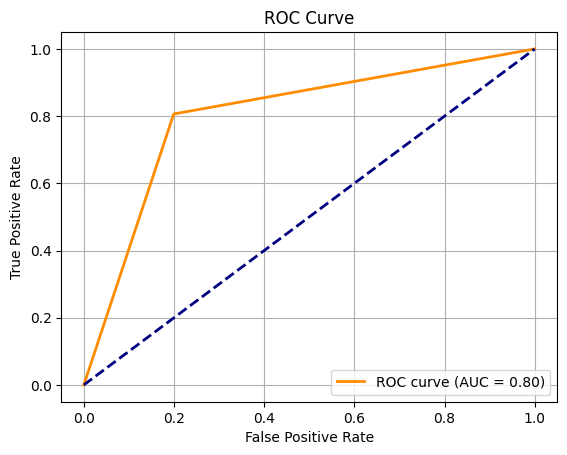

Not Fractured Accuracy: 100.00%
Fractured Accuracy: 100.00%


In [11]:
# --- ROC Curve & Per-Class Accuracy ---
from sklearn.metrics import roc_curve, auc, accuracy_score

# ROC Curve
fpr, tpr, _ = roc_curve(all_labels, all_preds)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Per-Class Accuracy
labels = ["Not Fractured", "Fractured"]
for i, label in enumerate(labels):
    idx = (all_labels == i)
    acc = accuracy_score([all_labels[idx]], [all_preds[idx]])
    print(f"{label} Accuracy: {acc*100:.2f}%")

## Grad-CAM

**Description**: This code block uses Grad-CAM (Gradient-weighted Class Activation Mapping) to visualize the areas of the input image that are most important for the model's prediction. It selects a random image from the validation set, performs a forward pass, and then uses Grad-CAM to generate a heatmap highlighting the relevant regions. Finally, it displays the original image and the heatmap side-by-side with labels and predictions.

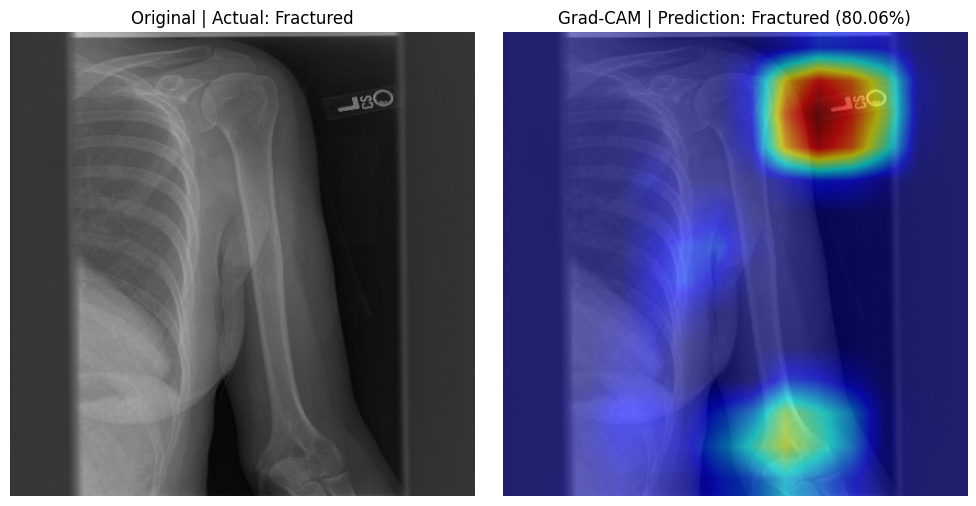

In [57]:
# Pick a random sample from the validation set
random_idx = random.randint(0, len(val_set) - 1)
image_tensor, label = val_set[random_idx]
# Forward pass for prediction
model.eval()
with torch.no_grad():
    input_tensor = image_tensor.unsqueeze(0).to(device)
    output = model(input_tensor)
    pred_prob = torch.sigmoid(output).item()
    pred_class = int(pred_prob > 0.5)

# Label formatting
# Add a not sure prediction when the probability is close to 50%.
label_text = "Fractured" if int(label.item()) == 1 else "Not Fractured"
if pred_class == 1:
    pred_text = "Fractured"
else:
    pred_text = "Not Fractured"

# Grad-CAM setup
target_layer = model.features[-1]
cam = GradCAM(model=model, target_layers=[target_layer])
grayscale_cam = cam(input_tensor=input_tensor, targets=[BinaryClassifierOutputTarget(1)])[0]

# Prepare images
img_np = image_tensor.permute(1, 2, 0).numpy()
img_np = (img_np * 0.5) + 0.5
gradcam_img = show_cam_on_image(img_np, grayscale_cam, use_rgb=True)

# Side-by-side with labels
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(img_np)
plt.title(f"Original | Actual: {label_text}")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(gradcam_img)
if pred_class == 1:
    plt.title(f"Grad-CAM | Prediction: {pred_text} ({pred_prob * 100:.2f}%)")
else:
  plt.title(f"Grad-CAM | Prediction: {pred_text} ({100 - pred_prob:.2f}%)")
plt.axis("off")

plt.tight_layout()
plt.show()